In [ ]:
# Numéros des lignes à garder
keep_rows = [12, 29, 39, 40, 41, 42, 43, 44, 53, 66]

# Ouverture du fichier et lecture des lignes
with open("GSE148375_series_matrix.txt", "r") as f:
    lines = f.readlines()

# Création d'une liste avec les lignes à garder
new_lines = []
for i, line in enumerate(lines):
    if i in keep_rows:
        new_lines.append(line)

# Écriture des lignes dans un nouveau fichier
with open("new_GSE148375_series_matrix.txt", "w") as f:
    for line in new_lines:
        f.write(line)


In [ ]:
# Numéros des lignes à garder
keep_rows = [1,2,3,4,5,6,7]

# Ouverture du fichier et lecture des lignes
with open("new_GSE148375_series_matrix.txt", "r") as f:
    lines = f.readlines()

# Création d'une liste avec les lignes à garder
new_lines = []
for i, line in enumerate(lines):
    if i in keep_rows:
        new_lines.append(line)

# Écriture des lignes dans un nouveau fichier
with open("new_GSE148375_series_matrix.txt", "w") as f:
    for line in new_lines:
        f.write(line)

In [ ]:
with open('new_GSE148375_series_matrix.txt', 'r') as input_file:
    # Lecture des lignes du fichier
    lines = input_file.readlines()
    
    # Création d'une liste de listes contenant les valeurs
    values = [line.strip().split('\t') for line in lines]
    
    # Calcul du nombre de colonnes et de lignes
    num_cols = len(values[0])
    num_rows = len(values)
    
    # Initialisation d'une liste de listes pour stocker les colonnes transposées
    transposed = [[] for i in range(num_cols)]
    
    # Itération sur les lignes pour remplir les colonnes transposées
    for row in values:
        for i in range(num_cols):
            transposed[i].append(row[i])
    
    # Écriture des colonnes transposées dans un nouveau fichier CSV
    with open('new_GSE148375_series_matrix.txt', 'w') as output_file:
        for row in transposed:
            output_file.write('\t'.join(row) + '\n')


In [ ]:
def remove_quotes(text):
    if len(text) > 1:
        return text[1:-1]
    else:
        return ''


In [ ]:
print(remove_quotes("'un'"))

In [14]:
from pyspark.sql import SparkSession

# Initialisation de la session Spark
spark = SparkSession.builder \
        .appName("MonApp") \
        .getOrCreate()

In [33]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# Définir le schéma pour le DataFrame
schema_pheno = StructType([
    StructField("Age", StringType(), True),
    StructField("Gender", StringType(), True),
    StructField("cpd", StringType(), True),
    StructField("hsi", StringType(), True),
    StructField("ftnd", StringType(), True),
    StructField("Smoking_status", StringType(), True),
    StructField("ID", StringType(), True)
])

# Charger le fichier CSV dans un DataFrame
df = spark.read.csv("new_GSE148375_series_matrix.txt", sep="\t", header=True, schema=schema_pheno)


In [30]:
df.count()

3399

In [31]:
df.columns

['Age', 'Gender', 'cpd', 'hsi', 'ftnd', 'Smoking_status', 'ID']

In [34]:
df.show(5)

+-------+--------------+-------+------+-------+--------------------+------+
|    Age|        Gender|    cpd|   hsi|   ftnd|      Smoking_status|    ID|
+-------+--------------+-------+------+-------+--------------------+------+
|age: 39|  gender: Male|cpd: 20|hsi: 4|ftnd: 7|smoking_status: S...|200026|
|age: 42|  gender: Male|cpd: 30|hsi: 5|ftnd: 9|smoking_status: S...|200027|
|age: 32|gender: Female|cpd: 40|hsi: 6|ftnd: 9|smoking_status: S...|200028|
|age: 33|  gender: Male|cpd: 20|hsi: 4|ftnd: 7|smoking_status: S...|200032|
|age: 48|gender: Female|cpd: 10|hsi: 3|ftnd: 5|smoking_status: S...|200033|
+-------+--------------+-------+------+-------+--------------------+------+
only showing top 5 rows



In [35]:
def get_last_word(text):
    """Retourne le dernier mot dans une chaîne de caractères"""
    if text is None:
        return None
    words = text.split()
    if len(words) > 0:
        return words[-1]
    else:
        return None

In [38]:
get_last_word("age: 39")

'39'

In [39]:
from pyspark.sql.functions import udf

# Définir la fonction UDF
remove_udf = udf(get_last_word, StringType())

# Appliquer la fonction à toutes les colonnes
for col in df.columns:
    df = df.withColumn(col, remove_udf(col))


In [40]:
df.show(5)

+---+------+---+---+----+--------------+------+
|Age|Gender|cpd|hsi|ftnd|Smoking_status|    ID|
+---+------+---+---+----+--------------+------+
| 39|  Male| 20|  4|   7|        Smoker|200026|
| 42|  Male| 30|  5|   9|        Smoker|200027|
| 32|Female| 40|  6|   9|        Smoker|200028|
| 33|  Male| 20|  4|   7|        Smoker|200032|
| 48|Female| 10|  3|   5|        Smoker|200033|
+---+------+---+---+----+--------------+------+
only showing top 5 rows



In [47]:
#Nom des colonnes
cols = df.columns

# Index des colonnes à permuter
i, j = 3, 5

# Générer la liste des colonnes avec la permutation
new_cols = [cols[k] if k not in (i, j) else cols[j + i - k] for k in range(len(cols))]
df=df.select(new_cols)

In [48]:
df.columns

['ID', 'Gender', 'Age', 'Smoking_status', 'ftnd', 'hsi', 'cpd']

In [49]:
# Fusionner toutes les partitions en une seule
df = df.coalesce(1)

# Enregistrer les données dans un seul fichier CSV
df.write.format("csv").option("header", True).option("delimiter", "\t").save("Phenotype")

In [52]:
from pyspark.sql.functions import mean, stddev, min, max

result = df.agg(*[mean(c).alias("mean_" + c) for c in df.columns] + 
               [stddev(c).alias("stddev_" + c) for c in df.columns] + 
               [min(c).alias("min_" + c) for c in df.columns] + 
               [max(c).alias("max_" + c) for c in df.columns]).collect()

print(result)


23/05/05 21:42:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(mean_ID=2018234.0523683436, mean_Gender=None, mean_Age=42.42247719917623, mean_Smoking_status=None, mean_ftnd=-0.5016181229773463, mean_hsi=-2.290379523389232, mean_cpd=12.783171521035598, stddev_ID=377450.8879061292, stddev_Gender=None, stddev_Age=13.500412248648415, stddev_Smoking_status=None, stddev_ftnd=8.775932581341731, stddev_hsi=6.90583249774269, stddev_cpd=13.983775150319033, min_ID='1900017', min_Gender='Female', min_Age='16', min_Smoking_status='Ex-smoker', min_ftnd='-9', min_hsi='-9', min_cpd='-9', max_ID='215827', max_Gender='Male', max_Age='88', max_Smoking_status='Smoker', max_ftnd='9', max_hsi='6', max_cpd='8')]


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_pandas=pd.read_csv("Phenotype/part-00000-f40e2b0b-25ae-4e3a-84d6-9f2b966e342d-c000.csv", sep="\t")

In [56]:
df_pandas["Age"].describe()

count    3399.000000
mean       42.422477
std        13.500412
min        16.000000
25%        31.000000
50%        43.000000
75%        52.000000
max        88.000000
Name: Age, dtype: float64

In [59]:
df_pandas["cpd"].describe()

count    3399.000000
mean       12.783172
std        13.983775
min        -9.000000
25%         0.000000
50%         0.000000
75%        25.000000
max        60.000000
Name: cpd, dtype: float64

In [60]:
df_pandas["hsi"].describe()

count    3399.000000
mean       -2.290380
std         6.905832
min        -9.000000
25%        -9.000000
50%        -9.000000
75%         5.000000
max         6.000000
Name: hsi, dtype: float64

In [61]:
df_pandas["ftnd"].describe()

count    3399.000000
mean       -0.501618
std         8.775933
min        -9.000000
25%        -9.000000
50%        -9.000000
75%         9.000000
max        10.000000
Name: ftnd, dtype: float64

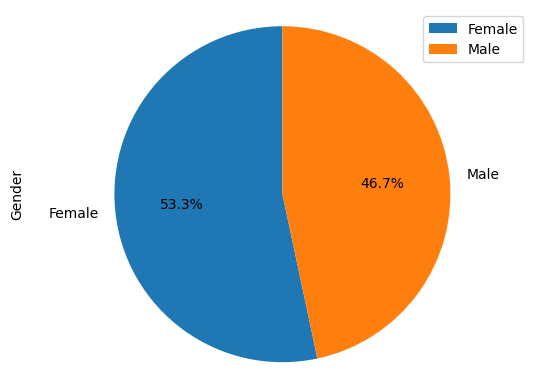

In [63]:
import matplotlib.pyplot as plt

# Calcul de la proportion de chaque genre dans la colonne "Genre"
counts = df_pandas['Gender'].value_counts(normalize=True)

# Tracé du diagramme circulaire
counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.legend()
plt.show()

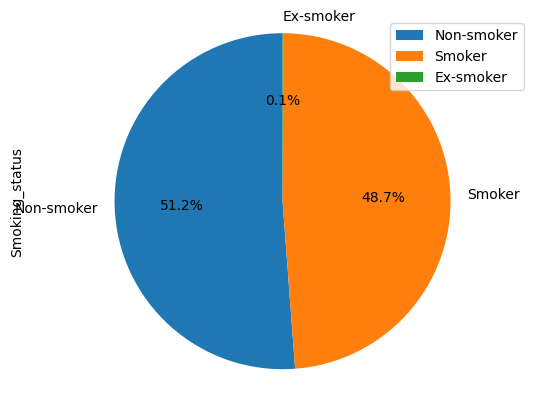

In [64]:
# Calcul de la proportion de chaque genre dans la colonne "Genre"
counts = df_pandas['Smoking_status'].value_counts(normalize=True)

# Tracé du diagramme circulaire
counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.legend()
plt.show()

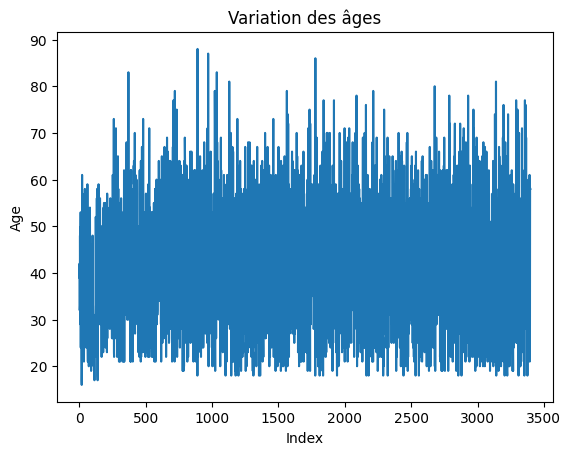

In [68]:
# Tracer la courbe de la variation des âges
plt.plot(df_pandas["Age"])

# Configurer les axes et les titres
plt.xlabel('Index')
plt.ylabel('Age')
plt.title('Variation des âges')
plt.show()

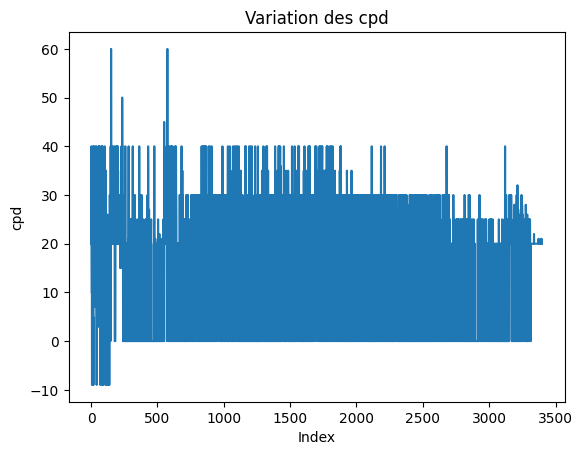

In [69]:
# Tracer la courbe de la variation des âges
plt.plot(df_pandas["cpd"])

# Configurer les axes et les titres
plt.xlabel('Index')
plt.ylabel('cpd')
plt.title('Variation des cpd')
plt.show()

/tmp/ipykernel_6153/3672880049.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pivot_table.plot.pie(subplots=True, ax=ax, autopct='%1.1f%%', startangle=90)


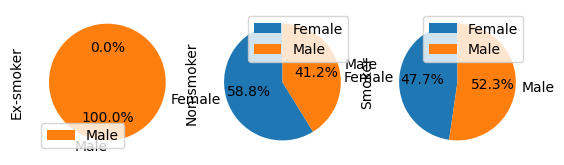

In [4]:
# Grouper les données par Gender et Smoking_status et compter le nombre d'occurrences
grouped = df_pandas.groupby(['Gender', 'Smoking_status']).size().reset_index(name='Count')

# Créer un pivot table à partir des données groupées pour faciliter la création du graphique
pivot_table = pd.pivot_table(grouped, values='Count', index='Gender', columns='Smoking_status', aggfunc=sum)

# Créer le diagramme circulaire
fig, ax = plt.subplots()
pivot_table.plot.pie(subplots=True, ax=ax, autopct='%1.1f%%', startangle=90)

# Ajouter un titre au graphique
ax.set_title('Proportion of Male/Female smokers/non-smokers')

# Afficher le graphique
plt.show()
